# Analysis of performance variation of parallel I/O

This notebook analyses the performance variation for write the single shared file (SSF) and file per process (FPP) on ARCHER.

Results are from the benchio benchmark

## Setup section

Load the required modules and setup useful functions

### Utiliity modules

In [1]:
import sys
import os.path
import re
from glob import glob
from datetime import datetime

### Analysis and visualisation modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 9})
matplotlib.rcParams.update({'figure.autolayout': True})
from matplotlib import dates
import seaborn as sns
%matplotlib inline

Function to read benchmark results from file

In [85]:
def readResults(filename):
    infile = open(filename, 'r')
    # Get date of test from file name
    tokens = filename.split('_')
    datestring = tokens[-1].split('.')[0]
    runtime = datetime.strptime(datestring, "%Y%m%d%H%M%S")
    resdict = {}
    resframe_proto = []
    resdict['JobID'] = 'Unknown'
    for line in infile:
        if re.search('MPI-IO', line):
            break
        elif re.search('Starting job', line):
            tokens = line.split()
            resdict['JobID'] = tokens[2]
        elif re.search('Running', line):
            tokens = line.split()
            resdict['Writers'] = int(tokens[2])
        elif re.search('Array', line):
            tokens = line.split()
            x = int(tokens[4])
            y = int(tokens[6])
            z = int(tokens[8])
            resdict['LocalSize'] = (x, y, z)
        elif re.search('Global', line):
            tokens = line.split()
            x = int(tokens[4])
            y = int(tokens[6])
            z = int(tokens[8])
            resdict['GlobalSize'] = (x, y, z)
        elif re.search('Total', line):
            tokens = line.split()
            resdict['TotData'] = float(tokens[5])
    infile.close()
    infile = open(filename, 'r')
    timedict = resdict.copy()
    for line in infile:
        if re.search('HDF5', line):
            break
        elif re.search('Writing to', line):
            tokens = line.split()
            if re.match('striped', tokens[2]):
                timedict['Striping'] = -1
            elif re.match('defstriped', tokens[2]):
                timedict['Striping'] = 4
        elif re.match(' time', line):
            tokens = line.split()
            timedict['Write'] = float(tokens[6])
            timedict['File'] = os.path.abspath(filename)
            timedict['RunDate'] = runtime
            timedict['Count'] = 1
            resframe_proto.append(timedict)
            # Striping is only captured once for each set so need to preset this for all following datum
            curstriping = timedict['Striping']
            timedict = resdict.copy()
            timedict['Striping'] = curstriping         
    infile.close()
    return resframe_proto

# Analysis

## Single Shared File (SSF)

In [5]:
indir = '../benchio/results/32/ARCHER/fs3'
filelist = glob(os.path.join(indir, 'benchio_res_' + '*' ))
filelist.sort()

In [13]:
tframe = []
for filename in filelist:
    arr = readResults(filename)
    tframe.extend(arr)

Create the dataframe and restrict to maximum striping results

In [42]:
resframe = pd.DataFrame(tframe)
resframe = resframe[resframe.Striping == -1]

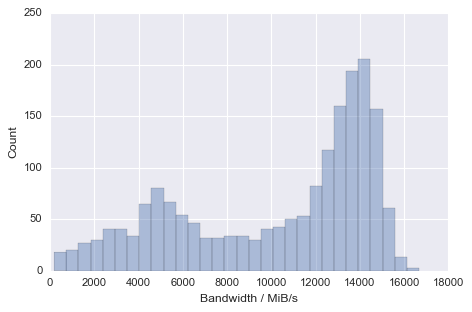

In [44]:
fig, ax = plt.subplots()
# plt.hist(resframe['Write'].tolist(), histtype='step', linewidth=2, alpha=0.5)
sns.distplot(resframe['Write'].tolist(), bins=30, kde=False, rug=False);
plt.xlabel('Bandwidth / MiB/s')
plt.ylabel('Count')

## Performance vs. date

Look to see if there are any particular periods where the performance is poor.

Aggregate the performance results for each day to assist analysis

In [50]:
groupf = {'Write':['min','median','max','mean'], 'Count':'sum'}
dateset = resframe.groupby('RunDate').agg(groupf)

In all the following plots the shaded area spans the minimum to maximum bandwidth for that day and the line shows the median bandwidth.

First, we show the full range of data and then zoom in on each of the 6 month periods. There was a gap in data collection from May-July 2017.

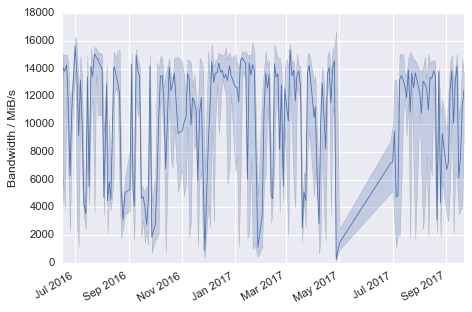

In [97]:
fig = plt.figure(1)
ax = plt.subplot(1, 1, 1)
fig.autofmt_xdate()
ax.set_ylabel('Bandwidth / MiB/s')
ax.plot_date(dateset.index.tolist(), dateset['Write','median'].tolist(), '-', linewidth=0.75)
ax.fill_between(dateset.index.tolist(), dateset['Write','min'].tolist(), dateset['Write','max'].tolist(), alpha=0.25)

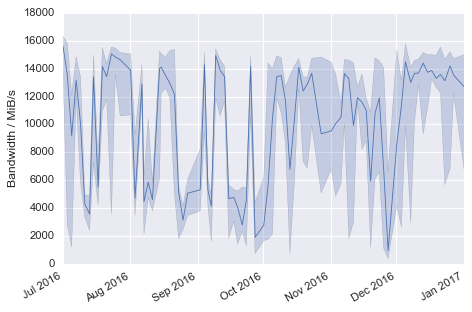

In [98]:
start = datetime(2016, 7, 1)
end = datetime(2017, 1, 1)
fig = plt.figure(1)
ax = plt.subplot(1, 1, 1)
fig.autofmt_xdate()
ax.set_ylabel('Bandwidth / MiB/s')
ax.set_xlim([start, end])
ax.plot_date(dateset.index.tolist(), dateset['Write','median'].tolist(), '-', linewidth=0.75)
ax.fill_between(dateset.index.tolist(), dateset['Write','min'].tolist(), dateset['Write','max'].tolist(), alpha=0.25)

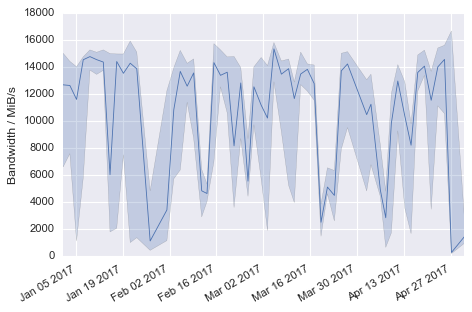

In [94]:
start = datetime(2017, 1, 1)
end = datetime(2017, 5, 1)
fig = plt.figure(1)
ax = plt.subplot(1, 1, 1)
fig.autofmt_xdate()
ax.set_ylabel('Bandwidth / MiB/s')
ax.set_xlim([start, end])
ax.plot_date(dateset.index.tolist(), dateset['Write','median'].tolist(), '-', linewidth=0.75)
ax.fill_between(dateset.index.tolist(), dateset['Write','min'].tolist(), dateset['Write','max'].tolist(), alpha=0.25)

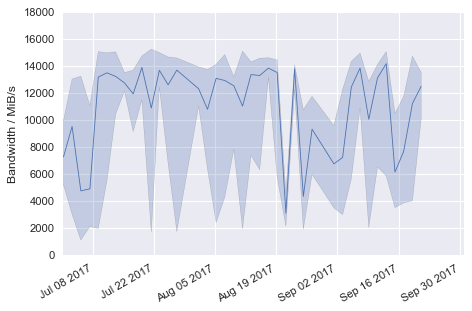

In [99]:
start = datetime(2017, 7, 1)
end = datetime(2017, 10, 1)
fig = plt.figure(1)
ax = plt.subplot(1, 1, 1)
fig.autofmt_xdate()
ax.set_ylabel('Bandwidth / MiB/s')
ax.set_xlim([start, end])
ax.plot_date(dateset.index.tolist(), dateset['Write','median'].tolist(), '-', linewidth=0.75)
ax.fill_between(dateset.index.tolist(), dateset['Write','min'].tolist(), dateset['Write','max'].tolist(), alpha=0.25)

This final period: Jul - Sep 2017 generally shows less variation in the median than the earlier periods possibly indicating more consistent performance.